## 1. Libraries and data

In [17]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

import pickle

In [18]:
# Load data
data = pd.read_csv("training_data/sales.csv")

## 2. EDA

In [19]:
# Explore the data
display(data.sample(10))
display(data.info())
print("Max sale:", data["sales"].max())

,Unnamed: 0,store_ID,day_of_week,date,nb_customers_on_day,open,promotion,state_holiday,school_holiday,sales
49211,702829,191,7,2015-06-28,0,0,0,0,0,0
224337,15277,310,1,2014-12-01,1079,1,1,0,0,15044
433387,301234,136,1,2013-10-14,422,1,0,0,0,5155
420361,2638,238,7,2015-02-08,0,0,0,0,0,0
604220,329142,410,3,2014-01-15,729,1,0,0,0,4912
30603,449282,644,4,2014-05-15,884,1,0,0,0,7128
410385,469672,264,1,2014-05-12,898,1,0,0,0,6083
15853,408306,822,3,2014-05-07,658,1,1,0,0,9232
429614,76089,642,4,2014-03-27,406,1,0,0,0,2959
509178,558580,400,6,2014-05-03,895,1,0,0,0,5916


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640840 entries, 0 to 640839
Data columns (total 10 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   Unnamed: 0           640840 non-null  int64 
 1   store_ID             640840 non-null  int64 
 2   day_of_week          640840 non-null  int64 
 3   date                 640840 non-null  object
 4   nb_customers_on_day  640840 non-null  int64 
 5   open                 640840 non-null  int64 
 6   promotion            640840 non-null  int64 
 7   state_holiday        640840 non-null  object
 8   school_holiday       640840 non-null  int64 
 9   sales                640840 non-null  int64 
dtypes: int64(8), object(2)
memory usage: 48.9+ MB


None

Max sale: 41551


In [20]:
# It's weird that state_holiday, let's see why
display(data["state_holiday"].unique())

array(['0', 'a', 'c', 'b'], dtype=object)

In [21]:
def data_eda(df):
    # There are three different state holidays, so we'll one-hot-encode them
    df = pd.get_dummies(df, columns=["state_holiday"], prefix="state_holiday", drop_first=True)

    # We'll one-hot-encode day_of_week too so every day is equally important
    df = pd.get_dummies(df, columns=["day_of_week"], prefix="day_of_week", drop_first=False)

    # We'll turn date into an integer too
    df['date'] = df['date'].str.replace('-', '').astype('int64')

    df = df.replace({True:1,False:0})

    # We don't need "Unnamed: 0"
    df = df.drop("Unnamed: 0", axis=1)
    
    return df

In [22]:
data = data_eda(data)

C:\Users\Saul\AppData\Local\Temp\ipykernel_16360\4084594816.py:11: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace({True:1,False:0})


In [23]:
display(data.sample(10))
display(data.info())

,store_ID,date,nb_customers_on_day,open,promotion,school_holiday,sales,state_holiday_a,state_holiday_b,state_holiday_c,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,day_of_week_7
346334,119,20140121,739,1,1,0,7325,0,0,0,0,1,0,0,0,0,0
95041,1068,20131211,278,1,0,0,3817,0,0,0,0,0,1,0,0,0,0
624358,872,20140504,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
274260,825,20140505,603,1,1,0,5039,0,0,0,1,0,0,0,0,0,0
580676,847,20130206,1061,1,1,0,7201,0,0,0,0,0,1,0,0,0,0
503215,80,20150718,668,1,0,0,8141,0,0,0,0,0,0,0,0,1,0
19031,796,20150718,437,1,0,0,5098,0,0,0,0,0,0,0,0,1,0
27226,323,20150329,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
447546,380,20141125,1487,1,1,0,16293,0,0,0,0,1,0,0,0,0,0
230807,172,20150326,763,1,0,0,6080,0,0,0,0,0,0,1,0,0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 640840 entries, 0 to 640839
Data columns (total 17 columns):
 #   Column               Non-Null Count   Dtype
---  ------               --------------   -----
 0   store_ID             640840 non-null  int64
 1   date                 640840 non-null  int64
 2   nb_customers_on_day  640840 non-null  int64
 3   open                 640840 non-null  int64
 4   promotion            640840 non-null  int64
 5   school_holiday       640840 non-null  int64
 6   sales                640840 non-null  int64
 7   state_holiday_a      640840 non-null  int64
 8   state_holiday_b      640840 non-null  int64
 9   state_holiday_c      640840 non-null  int64
 10  day_of_week_1        640840 non-null  int64
 11  day_of_week_2        640840 non-null  int64
 12  day_of_week_3        640840 non-null  int64
 13  day_of_week_4        640840 non-null  int64
 14  day_of_week_5        640840 non-null  int64
 15  day_of_week_6        640840 non-null  int64
 16  da

None

## 3. Correlation Matrix

,store_ID,date,nb_customers_on_day,open,promotion,school_holiday,state_holiday_a,state_holiday_b,state_holiday_c,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,day_of_week_6,day_of_week_7
store_ID,1.000000,-0.000137,0.023605,-0.001108,-0.000364,-0.000706,0.001005,0.000016,-0.000866,0.000565,-0.000310,-0.000217,-0.000452,-0.000622,-0.000231,0.001274
date,-0.000137,1.000000,-0.000936,-0.001118,0.024148,-0.032965,0.010634,0.013868,-0.026057,-0.001592,-0.005026,0.000411,0.004461,0.003384,-0.001125,-0.000534
nb_customers_on_day,0.023605,-0.000936,1.000000,0.617264,0.315858,0.071085,-0.182142,-0.103493,-0.083525,0.157166,0.112621,0.077257,0.057364,0.096531,0.020972,-0.523083
open,-0.001108,-0.001118,0.617264,1.000000,0.294936,0.085213,-0.303459,-0.174644,-0.138651,0.130182,0.171875,0.156625,0.101176,0.131319,0.179124,-0.872404
promotion,-0.000364,0.024148,0.315858,0.294936,1.000000,0.066565,-0.004241,0.019809,-0.050382,0.130844,0.126291,0.126617,0.127710,0.127346,-0.320364,-0.319808
school_holiday,-0.000706,-0.032965,0.071085,0.085213,0.066565,1.000000,0.030275,0.158722,0.137570,0.061574,0.076997,0.063323,0.063588,0.073417,-0.169918,-0.169738
state_holiday_a,0.001005,0.010634,-0.182142,-0.303459,-0.004241,0.030275,1.000000,-0.011634,-0.009169,0.015762,-0.029268,-0.010675,0.128185,-0.002329,-0.049960,-0.052048
state_holiday_b,0.000016,0.013868,-0.103493,-0.174644,0.019809,0.158722,-0.011634,1.000000,-0.005217,0.083466,-0.033244,-0.033236,-0.033304,0.082602,-0.033172,-0.033114
state_holiday_c,-0.000866,-0.026057,-0.083525,-0.138651,-0.050382,0.137570,-0.009169,-0.005217,1.000000,-0.026081,-0.026200,0.024550,0.063454,0.016209,-0.026144,-0.026098
day_of_week_1,0.000565,-0.001592,0.157166,0.130182,0.130844,0.061574,0.015762,0.083466,-0.026081,1.000000,-0.166198,-0.166161,-0.166501,-0.166676,-0.165839,-0.165551


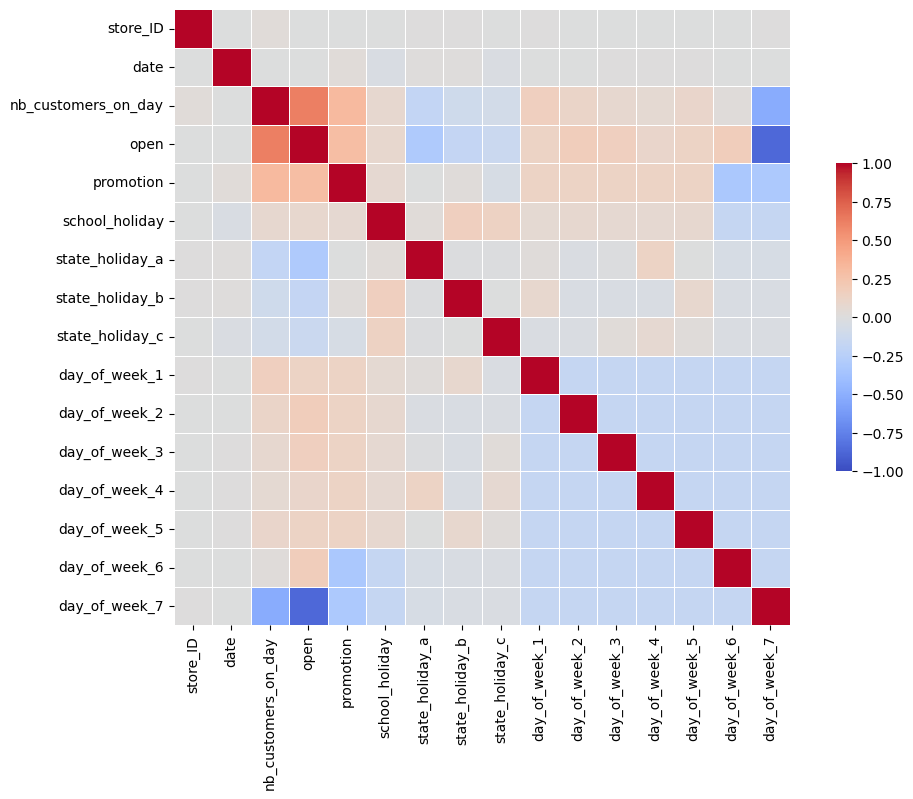

In [27]:
# Check correlation between features
corr = data.drop("sales",axis=1).corr()
display(corr)

plt.figure(figsize=(12, 8))
sns.heatmap(corr, vmax=1, vmin=-1, square=True, linewidths=.5, cmap="coolwarm", cbar_kws={"shrink": .5}) # Most of these arguments are not really useful in this case
plt.show()

# It seems that there is a somewhat high correlation between Sundays (day_of_week_7) and closed stores (open=0), but not strong enough to drop any of these features

## 4. Feature Scaling (Standardization)

In [28]:
scaler = StandardScaler()

X = data.drop("sales",axis=1)
y = data["sales"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

X_train = pd.DataFrame(scaler.fit_transform(X_train), columns=X.columns) # We train the scaler only with the training data!
X_test = pd.DataFrame(scaler.transform(X_train), columns=X.columns) # We scale the test data with the weights of the trained scaler (only transform, don't fit_transform)

## 5. Model Cross Validation

In [30]:
# Define the models and the sample size
models = {
    "Linear Regression": LinearRegression(),
    "Decision Tree_4": DecisionTreeRegressor(max_depth=4),
    "Decision Tree_5": DecisionTreeRegressor(max_depth=5),
    "Random Forest_50": RandomForestRegressor(n_estimators=50),
    "Random Forest": RandomForestRegressor(n_estimators=100),
    "Random Forest_200": RandomForestRegressor(n_estimators=200),
    "KNN_3": KNeighborsRegressor(n_neighbors=3),
    "KNN_5": KNeighborsRegressor(n_neighbors=5),
    "KNN_7": KNeighborsRegressor(n_neighbors=7),
    "SVR_rbf": SVR(kernel="rbf"),
    "SVR_linear": SVR(kernel="linear"),
    "GBR": GradientBoostingRegressor(n_estimators=2000, learning_rate=0.3)
}

sample_size = 3000

In [31]:
# Check the R2-score of each model and choose the best-performing ones
for name, model in models.items():
    scores = cross_val_score(model, X_train.head(sample_size), y_train.head(sample_size), scoring="r2")
    print(f"{name}: R2-score:\t{np.mean(scores):.5f}")

Linear Regression: R2-score:	0.85338
Decision Tree_4: R2-score:	0.83644
Decision Tree_5: R2-score:	0.85048
Random Forest_50: R2-score:	0.86352
Random Forest: R2-score:	0.86409
Random Forest_200: R2-score:	0.86476
KNN_3: R2-score:	0.79231
KNN_5: R2-score:	0.79611
KNN_7: R2-score:	0.79632
SVR_rbf: R2-score:	0.04299
SVR_linear: R2-score:	0.70941
GBR: R2-score:	0.88707


## 6. Hyperparameter Tuning

In [16]:
# Linear Regression
models["Linear Regression"].fit(X_train.head(sample_size),y_train.head(sample_size))
y_pred_LN = models["Linear Regression"].predict(X_train.tail(sample_size))
r2_LN = r2_score(y_train.tail(sample_size), y_pred_LN)
print(f"R2-score for Linear Regression ({sample_size} samples): {r2_LN:.5f}")

R2-score for Linear Regression (3000 samples): 0.85623


In [17]:
# Random Forest 
# tuned_RF = RandomizedSearchCV(estimator=models["Random Forest"], param_distributions={'n_estimators': [50, 100, 150, 200], 'max_depth': [10, 20, 30, None]}, cv=5, scoring='r2')

tuned_RF = RandomForestRegressor(n_estimators=100, max_depth=20)
tuned_RF.fit(X_train.head(sample_size),y_train.head(sample_size))
y_pred_RF = tuned_RF.predict(X_train.tail(sample_size))
r2_RF = r2_score(y_train.tail(sample_size), y_pred_RF)
print(f"R2-score for Random Forest ({sample_size} samples): {r2_RF:.5f}")

R2-score for Random Forest (3000 samples): 0.86647


In [12]:
# Gradient Boosting
# tuned_GB = RandomizedSearchCV(estimator=models["GBR"], param_distributions={'n_estimators': [250, 500, 1000, 2000], 'learning_rate': [0.1, 0.2, 0.3]}, cv=5, scoring='r2', verbose=3)

tuned_GB = GradientBoostingRegressor(n_estimators=250, learning_rate=0.3)
tuned_GB.fit(X_train.head(sample_size),y_train.head(sample_size))
y_pred_GB = tuned_GB.predict(X_train.tail(sample_size))
r2_GB = r2_score(y_train.tail(sample_size), y_pred_GB)
print(f"R2-score for Gradient Boosting ({sample_size} samples): {r2_GB:.5f}")

R2-score for Gradient Boosting (3000 samples): 0.88108


In [19]:
## We tried stacking three different models, but it was too computationally demanding
# base_models = [
#         ("ln", models["Linear Regression"]),
#         ("rf", tuned_RF),
#         ("gb", tuned_GB)
# ]

# meta_model = StackingClassifier(estimators=base_models, final_estimator=LogisticRegression())

# trained_model = meta_model.fit(X_train,y_train)
# y_pred_LN = trained_model.predict(X_test)
# r2_LN = r2_score(y_test, y_pred_LN)
# print(f"R2-score for Linear Regression: {r2_LN:.5f}")

## 7. Model Predictions

In [14]:
# We now test the best-scoring model with the whole dataset
trained_model = tuned_GB.fit(X_train,y_train)
y_pred = trained_model.predict(X_test)
r2 = r2_score(y_test, y_pred)
print(f"R2-score: {r2:.5f}")

R2-score: 0.93875


In [ ]:
# Once we know the approximate R2-score, we can retrain the model with the whole dataset
X = pd.DataFrame(scaler.fit_transform(X), columns=X.columns) # We retrain the original scaler with the whole dataset
trained_model = tuned_GB.fit(X,y) # We retrain the model with the whole dataset

## 8. Data Export

In [16]:
pickle.dump(trained_model, open("trained_model.pkl", "wb"))
pickle.dump(scaler, open("scaler.pkl", "wb"))